# Project Icaras: Analysis of commercial airflight data for sustainability

It has been know that the aviation has a huge impact on climate change, in fact it is responsible for around [3% of global emissions](https://www.sustainabilitybynumbers.com/p/aviation-climate-part-one). Global aviation emits around one billion tonnes per year, it is necessary to take action on this problem and start thinking out to reduce the emissions by looking for better and more sustainable alternatives. 

In this study, we will focus on one of the most polluted countries and try to tackle solutions to reduce carbon emissions. 

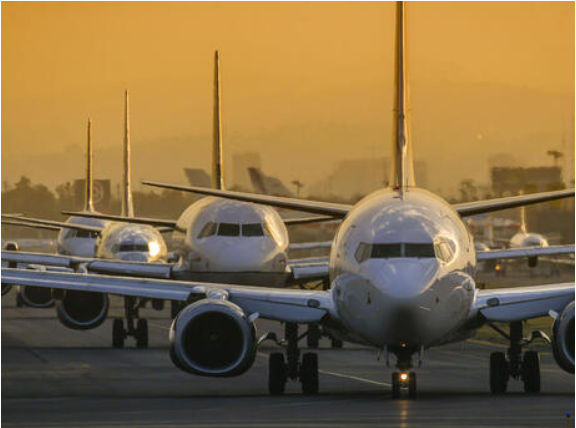

In [8]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('python_files')
from Class_Airplane import Airplane

plt.figure(figsize=(20, 16))
pd.set_option('display.max_columns', None)

<Figure size 2000x1600 with 0 Axes>

In [9]:
airplane = Airplane()

## Download the datasets (Method 1).

In [10]:
airplane.download_data()

### Let's look the dataset

Here is the dataset, we have been using for the analysis. 
It is better to clarify the dataset to understand our analysis. Here is an explanation of it:

**Airport ID**:
**Name**:\
**City**:\
**Source country**:\
**IATA**:\
**ICAO**:\
**latitude_source**:\
**longitude_source**:\
**Altitude**:\
**Timezone**:\
**DST**:\
**Tz database time zone**:\
**Airline**:\
**Timezone**:

Finishing the cleaning part, before.

In [11]:
airplane.merge_datasets()

,Airport ID,Name,City,Source country,IATA,ICAO,latitude_source,longitude_source,Altitude,Timezone,DST,Tz database time zone,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,Destination country,latitude_destination,longitude_destination
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,CG,1308,GKA,1,HGU,3,NaN,0.0,DH8 DHT,Papua New Guinea,-5.826790,144.296005
1,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,CG,1308,GKA,1,LAE,4,NaN,0.0,DH8,Papua New Guinea,-6.569803,146.725977
2,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,CG,1308,GKA,1,MAG,2,NaN,0.0,DH8,Papua New Guinea,-5.207080,145.789001
3,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,CG,1308,GKA,1,POM,5,NaN,0.0,DH8,Papua New Guinea,-9.443380,147.220001
4,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,PX,328,GKA,1,POM,5,NaN,0.0,DH4 DH8 DH3,Papua New Guinea,-9.443380,147.220001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71691,14102,Laguindingan Airport,Cagayan de Oro City,Philippines,CGY,RPMY,8.612203,124.456496,190,\N,\N,\N,PR,3952,CGY,2400,MNL,2397,NaN,0.0,320,Philippines,14.508600,121.019997
71698,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,H2,4737,CPO,4312,CJC,2645,NaN,0.0,319,Chile,-22.498199,-68.903603
71699,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,H2,4737,CPO,4312,LSC,2662,NaN,0.0,319,Chile,-29.916201,-71.199501
71700,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,H2,4737,CPO,4312,SCL,2650,NaN,0.0,320 319,Chile,-33.393002,-70.785797


## Calculating the distances between airports in kilometers (Method 2)

The following graph represents the real distances between airports in kilometers with the information in the datasets.  

C:\Users\ritac\anaconda3\lib\site-packages\plotnine\stats\binning.py:152: FutureWarning: The provided callable <function sum at 0x0000018E2141E790> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
C:\Users\ritac\anaconda3\lib\site-packages\plotnine\guides\guides.py:187: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


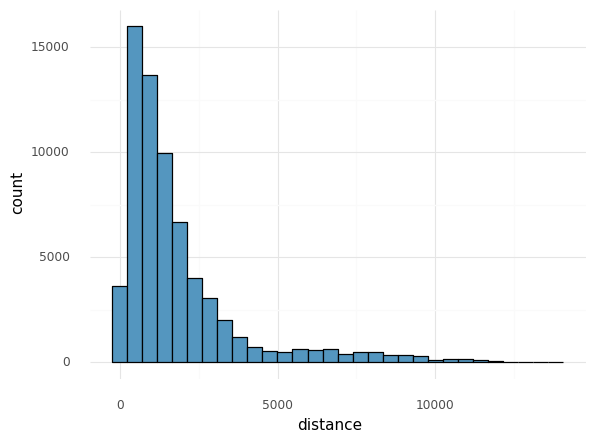

<ggplot: (106894243051)>

In [12]:
airplane.distance_analysis()

## Plotting routes from a given airport (Method 3)

Description...

C:\Users\ritac\OneDrive\Documenti\CLASSES\ADAPRO\Project\Class_Airplane.py:196: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


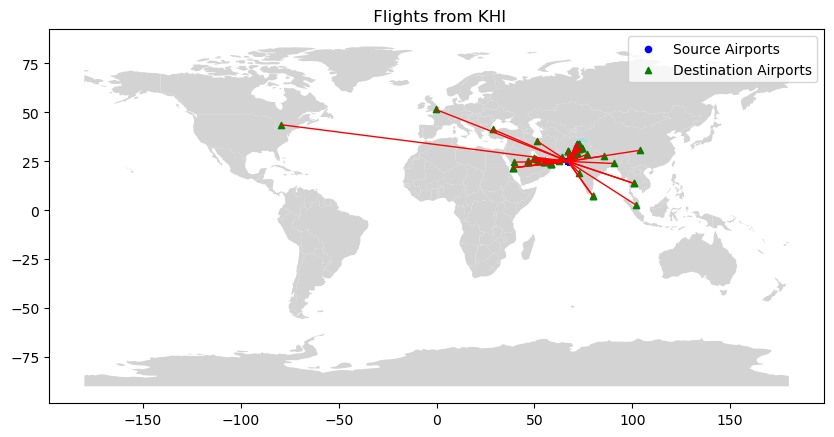

C:\Users\ritac\OneDrive\Documenti\CLASSES\ADAPRO\Project\Class_Airplane.py:196: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


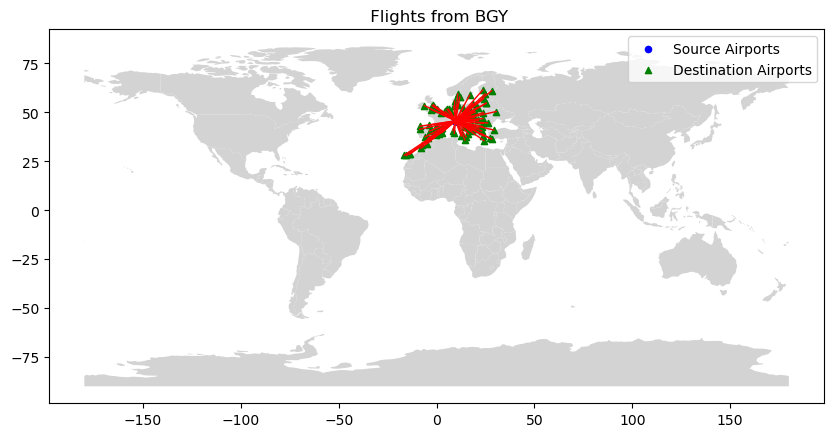

In [13]:
airplane.plot_flights_by_code_airports("KHI", internal=False) 
airplane.plot_flights_by_code_airports("BGY", internal=False) 

## Plotting histograms of top 5 airplane models by the number of routes (Method 4)

From these two histograms we can see that the most used destination airports from the airport BHV thath is in the india are the KHI, LHE and ISB and off this are located in Pakistan. When he do this for the HBX this have the most two flights to the airports BLR and BOM that they are both in India.

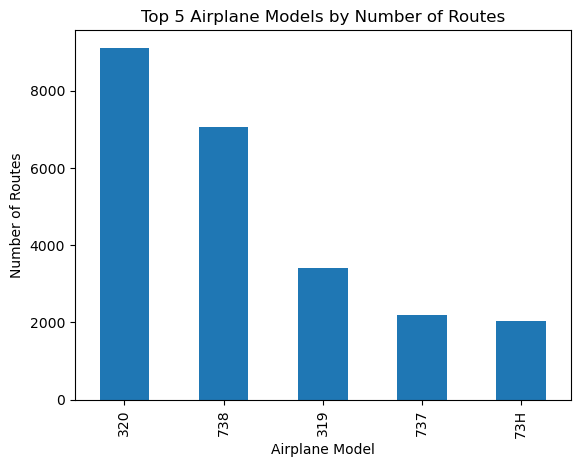

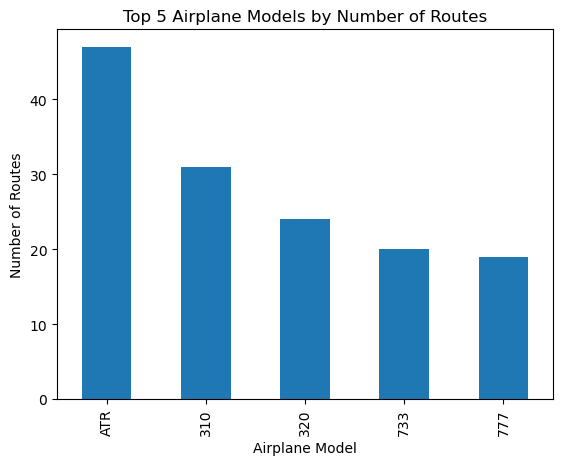

In [7]:
# Plot for the entire dataset
airplane.plot_most_used_airplane_models()

# Plot for a specific country or list of countries
airplane.plot_most_used_airplane_models(countries='Pakistan')

The top 5 models used in the world are the 320, 738,319, 737 and 73H but when we are looking at the top 5 airplanes models in the United State are the CRJ, 73W,320,738 and 319. If we compare only the model 320 is both top 5 model used.

## Method 5

The following method has the goal to plot the distances of the internal and external flights of the given country, such as China in our case. 

It is possible to distinguish between the short-haul flights and the long-haul flights based on the colours of the lines, which are red for the former and blue for the latter one. The default cut-off distance to separete the two typology is 1000km (based on [David Crocker](https://en.wikipedia.org/wiki/Flight_length) definition)


C:\Users\ritac\OneDrive\Documenti\CLASSES\ADAPRO\Project\Class_Airplane.py:308: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


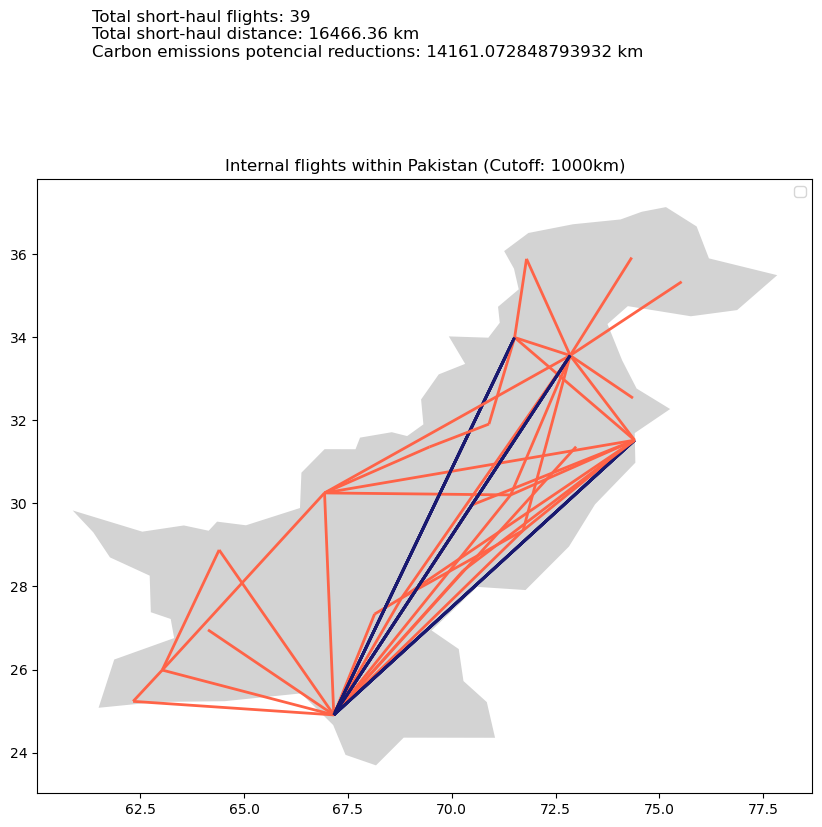

In [8]:
airplane.plot_flights_by_country("Pakistan", internal=True,cutoff_distance = 1000)

## Summury